In [1]:
cd ../related_post_gen/python

C:\Users\fizma\Desktop\job\related_post_gen\python


In [2]:
from subprocess import run, PIPE, STDOUT
from shutil import which
import sys
from glob import iglob
import pandas as pd
from io import StringIO
from tqdm.notebook import tqdm

In [3]:
def python(*args, **kwargs):
    result = run([sys.executable, *args], text=True, capture_output=True, **kwargs)
    if result.stderr:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(python("--version"))

Python 3.11.5



In [4]:
def git(*args, **kwargs):
    result = run([which("git"), *args], text=True, capture_output=True, **kwargs)
    if result.returncode:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(git("show", "-s"))

commit dd29880ce09a10c447ebf857264772e63edc8aad
Author: Ivan <fizmat.r66@gmail.com>
Date:   Mon Oct 2 10:17:46 2023 +0300

    try counter most_common



In [5]:
def k_input_columns(k):
    assert k in {5, 6}
    columns = ["counter", "import", "compile", "input", "process", "output"]
    if k == 5:
        return columns[:2] + columns[3:]
    return columns

In [6]:
TIME_COLUMNS = ["import", "input", "process", "output"]

In [7]:
COMMIT_MAP = {
    "python~6..python~3": ["related.py"],
    "test-most-common~1..test-most-common": ["related.py"],
    "python~5..test-partition": ["related_np.py"],
    "python..scipy-partition": ["related_scipy.py"],
    "python..dataframes~1": ["related_pd.py"],
    "dataframes~1..dataframes": ["related_pl.py"],
    "python..numba": ["related_numba.py"],
}

In [8]:
N = 20

In [9]:
def collect_times(commit_range, glob, n=N):
    data = []
    for i, h in enumerate(git("rev-list", "--reverse", commit_range, "--").splitlines()):
        git("checkout", h)
        subj = git("show", "-s", "--format=%s").strip()
        subj = f"{i}: {subj:.20}…"
        print(subj)
        for f in iglob(glob):
            if "duckdb" in f:
                continue
            print(f)
            # warm-up
            print(python(f))
            print(python(f, env={"DETAILED_PYTHON_PERF": "1"}))
            # measure
            buf = "\n".join(python(f, env={"DETAILED_PYTHON_PERF": "1"}).strip() 
                            for _ in tqdm(range(n)))
            record = pd.read_csv(StringIO(buf), sep="\t", header=None)
            record.columns = k_input_columns(len(record.columns))
            record["total"] = record.iloc[:, 1:].sum(axis=1)
            record.insert(0, "impl", f)
            record.insert(1, "commit", subj)
            data.append(record)
    return pd.concat(data)


In [10]:
times = pd.concat(collect_times(commit_range, g) for commit_range, globs in COMMIT_MAP.items() for g in globs) 

0: install all python d…
related.py
Processing time (w/o IO): 2.755s

perf_counter	0.012016262	0.010443576	2.734023668	0.479600969
process_time	0.015625	0.0	2.71875	0.484375



  0%|          | 0/20 [00:00<?, ?it/s]

1: minor pythonizations…
related.py
Processing time (w/o IO): 2.735s

perf_counter	0.012150636	0.010619157	2.761687798	0.485621427
process_time	0.0	0.015625	2.765625	0.484375



  0%|          | 0/20 [00:00<?, ?it/s]

2: use ujson for IO…
related.py
Processing time (w/o IO): 2.713s

perf_counter	0.006828591	0.010041011	2.693634386	0.053621341
process_time	0.0	0.015625	2.6875	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

0: try counter most_com…
related.py
Processing time (w/o IO): 2.814s

perf_counter	0.006835226	0.010042338	2.818082605	0.053267874
process_time	0.0	0.015625	2.8125	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

0: minor pythonizations…
related_np.py
Processing time (w/o IO): 0.772s

perf_counter	0.117205609	0.010345658	0.764950085	0.482793553
process_time	0.109375	0.015625	0.765625	0.484375



  0%|          | 0/20 [00:00<?, ?it/s]

1: use ujson for IO…
related_np.py
Processing time (w/o IO): 0.767s

perf_counter	0.117796536	0.010092065	0.791193433	0.054309766
process_time	0.0625	0.015625	0.78125	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

2: np: use python set t…
related_np.py
Processing time (w/o IO): 0.703s

perf_counter	0.116340276	0.009850833	0.707289683	0.052094121
process_time	0.078125	0.015625	0.703125	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

3: np: use smaller matr…
related_np.py
Processing time (w/o IO): 0.743s

perf_counter	0.122042257	0.01122482	0.755231671	0.052878019
process_time	0.109375	0.0	0.765625	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

4: np: use dict of tags…
related_np.py
Processing time (w/o IO): 0.701s

perf_counter	0.117505996	0.010012166	0.695087086	0.053314667
process_time	0.109375	0.015625	0.703125	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

5: try to use numpy par…
related_np.py
Processing time (w/o IO): 0.741s

perf_counter	0.121161837	0.010049043	0.747074209	0.05255207
process_time	0.109375	0.0	0.75	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

0: copy numpy matrix so…
related_scipy.py
Processing time (w/o IO): 0.701s

perf_counter	0.118364206	0.010039613	0.699769873	0.053252369
process_time	0.109375	0.015625	0.703125	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

1: use scipy sparse mat…
related_scipy.py
Processing time (w/o IO): 0.287s

perf_counter	0.209885195	0.00999268	0.285141408	0.05396908
process_time	0.203125	0.015625	0.28125	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

2: sort results directl…
related_scipy.py
Processing time (w/o IO): 0.246s

perf_counter	0.210919474	0.0099667	0.236062823	0.053561766
process_time	0.21875	0.0	0.234375	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

3: try to use numpy par…
related_scipy.py
Processing time (w/o IO): 0.245s

perf_counter	0.208588452	0.009924586	0.24493099	0.05160586
process_time	0.234375	0.015625	0.25	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

0: add python pandas va…
related_pd.py
Processing time (w/o IO): 7.889s

perf_counter	0.397750133	0.017334536	7.906506692	0.045083943
process_time	0.40625	0.015625	7.90625	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

0: add python polars va…
related_pl.py
Processing time (w/o IO): 1.404s

perf_counter	0.134059566	0.005437493	1.478254988	0.012075836
process_time	0.140625	0.0	7.75	0.015625



  0%|          | 0/20 [00:00<?, ?it/s]

0: add another numpy so…
related_numba.py
Processing time (w/o IO): 1.372s

perf_counter	0.133293966	3.772e-06	0.011870014	1.362067037	0.054367035
process_time	0.125	0.0	0.015625	1.359375	0.0625



  0%|          | 0/20 [00:00<?, ?it/s]

1: accelerate with numb…
related_numba.py
Processing time (w/o IO): 0.215s

perf_counter	0.388543237	0.510790407	0.010028649	0.213558497	0.052800007
process_time	0.390625	0.5	0.0	0.21875	0.046875



  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
times.insert(4, "compile", times.pop("compile").fillna(0))

In [12]:
times.commit = times.commit.str.slice(0, 20)+"…"

In [13]:
from uncertainties import ufloat

def pretty_stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: f"{ufloat(c.mean(), c.std()):.2ufP}")

table = times.groupby(["impl", "counter", "commit"]).apply(pretty_stddev)
table

import  \
impl             counter      commit                               
related.py       perf_counter 0: install all pytho…   11.90±0.18   
                              0: try counter most_…    7.09±0.18   
                              1: minor pythonizati…   12.08±0.28   
                              2: use ujson for IO……    7.12±0.23   
                 process_time 0: install all pytho…     11.7±6.9   
                              0: try counter most_…      7.0±8.0   
                              1: minor pythonizati…     10.9±7.3   
                              2: use ujson for IO……      6.2±7.9   
related_np.py    perf_counter 0: minor pythonizati…  115.92±0.72   
                              1: use ujson for IO……  117.47±0.82   
                              2: np: use python se…  118.21±0.91   
                              3: np: use smaller m…  117.74±0.82   
                              4: np: use dict of t…    118.3±1.3   
                              5: try to use numpy …  117.56±0.87   
                 process_time 0: minor pythonizati…       107±15   
                              1: use ujson for IO……       109±15   
                              2: np: use python se…       110±13   
                              3: np: use smaller m…       105±13   
                              4: np: use dict of t…       106±18   
                              5: try to use numpy …       108±16   
related_numba.py perf_counter 0: add another numpy…    118.7±1.2   
                              1: accelerate with n…    383.6±2.1   
                 process_time 0: add another numpy…       109±11   
                              1: accelerate with n…       355±22   
related_pd.py    perf_counter 0: add python pandas…    400.1±7.0   
                 process_time 0: add python pandas…       370±22   
related_pl.py    perf_counter 0: add python polars…    133.9±2.2   
                 process_time 0: add python polars…       122±15   
related_scipy.py perf_counter 0: copy numpy matrix…    118.7±2.2   
                              1: use scipy sparse …    210.9±1.9   
                              2: sort results dire…    210.7±3.0   
                              3: try to use numpy …    211.2±3.4   
                 process_time 0: copy numpy matrix…       110±14   
                              1: use scipy sparse …       184±14   
                              2: sort results dire…       193±15   
                              3: try to use numpy …       191±18   

                                                             compile  \
impl             counter      commit                                   
related.py       perf_counter 0: install all pytho…           0.00±0   
                              0: try counter most_…           0.00±0   
                              1: minor pythonizati…           0.00±0   
                              2: use ujson for IO……           0.00±0   
                 process_time 0: install all pytho…           0.00±0   
                              0: try counter most_…           0.00±0   
                              1: minor pythonizati…           0.00±0   
                              2: use ujson for IO……           0.00±0   
related_np.py    perf_counter 0: minor pythonizati…           0.00±0   
                              1: use ujson for IO……           0.00±0   
                              2: np: use python se…           0.00±0   
                              3: np: use smaller m…           0.00±0   
                              4: np: use dict of t…           0.00±0   
                              5: try to use numpy …           0.00±0   
                 process_time 0: minor pythonizati…           0.00±0   
                              1: use ujson for IO……           0.00±0   
                              2: np: use python se…           0.00±0   
                              3: np: use smaller m…           0.00±0   
                              4: 

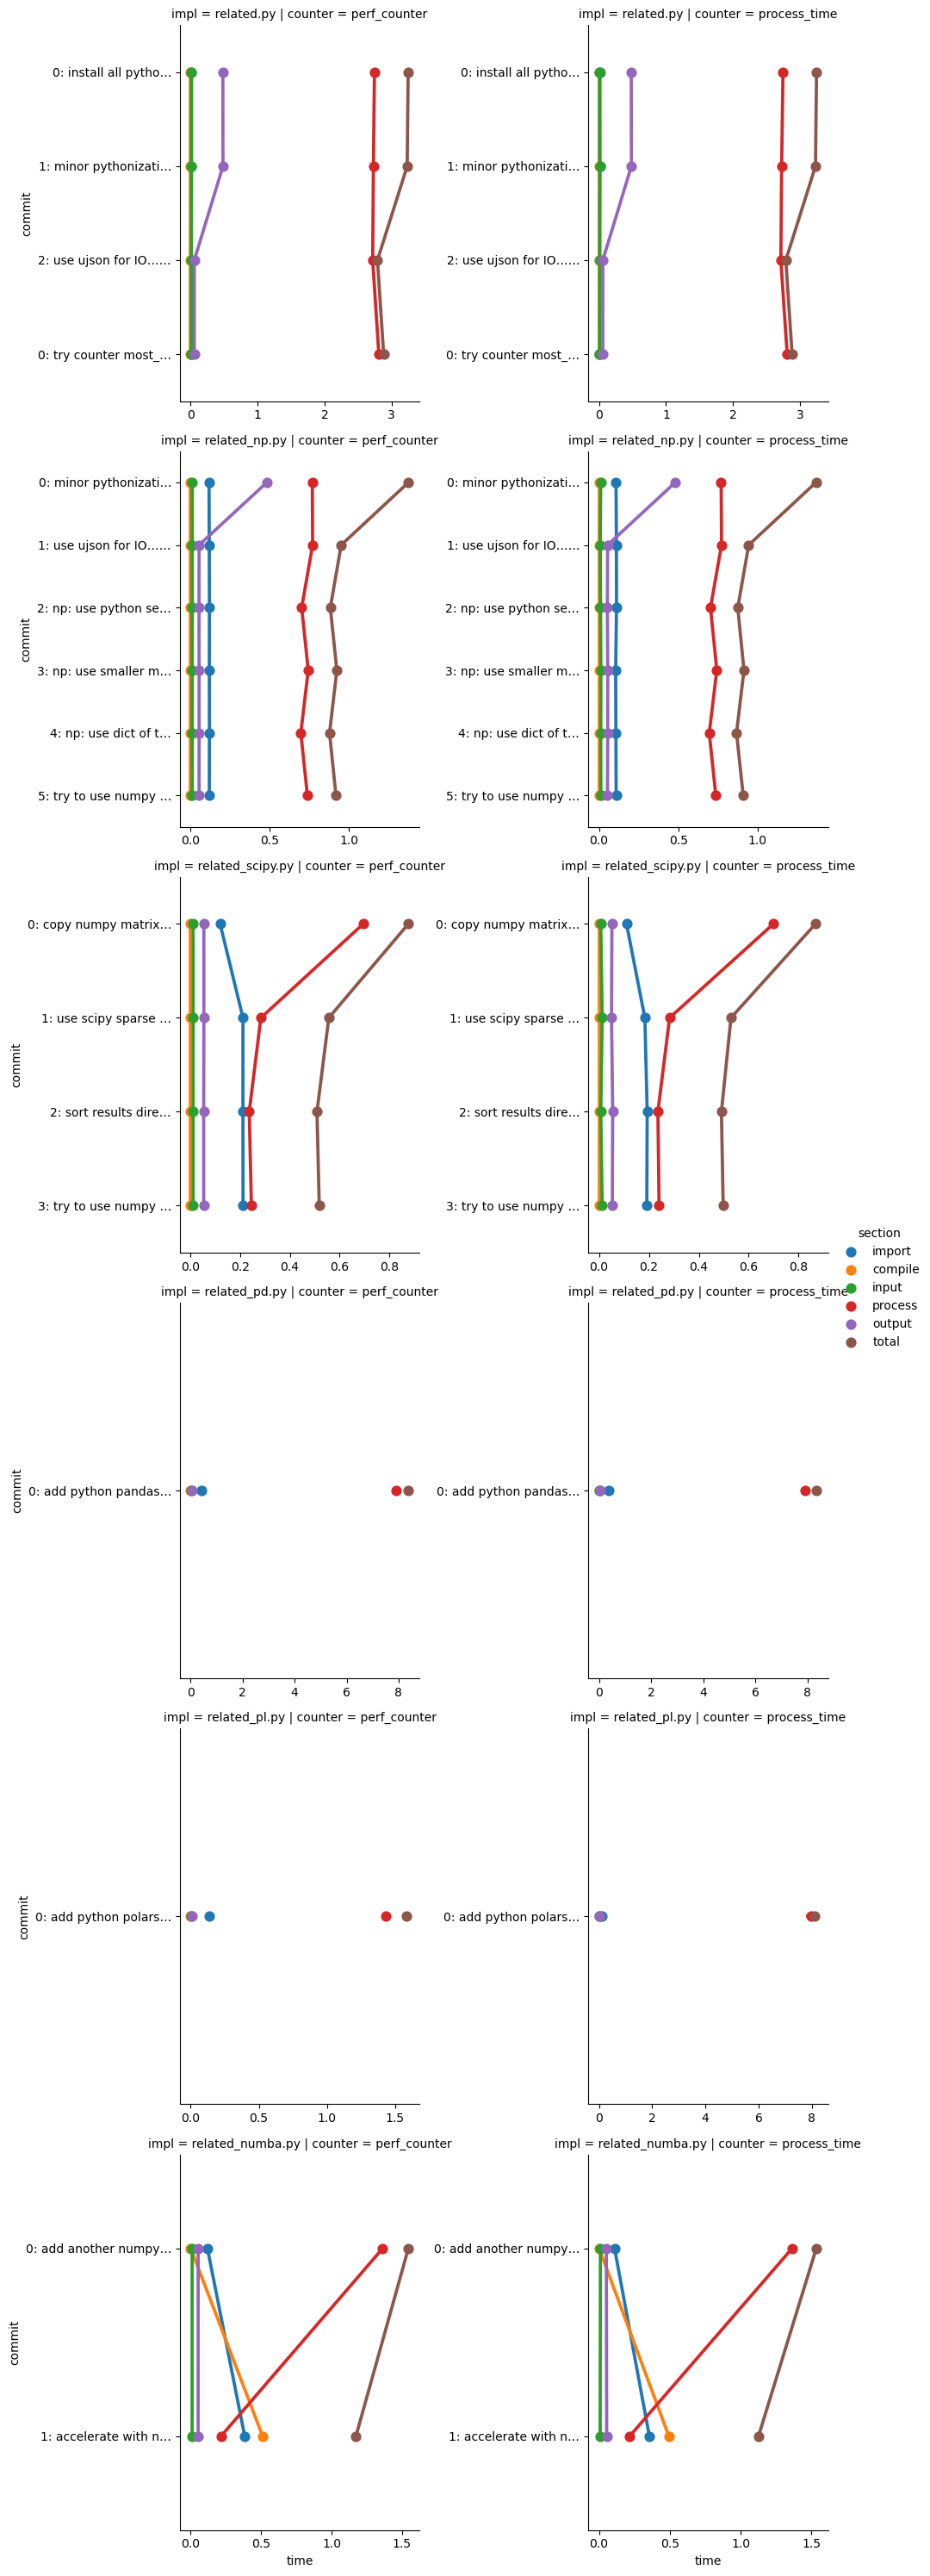

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

tidy = times.melt(id_vars=["impl", "commit", "counter"],
                  var_name="section", value_name="time")
grid = sns.catplot(tidy, hue="section", y="commit", x="time",
                   row="impl", col="counter", kind="point",
                  sharex=False, sharey=False)


In [15]:
def stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: ufloat(c.mean(), c.std()))

final_table = times.groupby(["counter", "impl", "commit"]).apply(stddev) \
    .groupby(level=[0,1]).last() \
    .reset_index() \
    .sort_values(["counter", "process"]) \
    .set_index(["counter", "impl"]) \
    .map(lambda v: f"{v:.2ufP}")
final_table

import    compile       input    process  \
counter      impl                                                              
perf_counter related_numba.py    383.6±2.1  510.9±1.6  10.11±0.19  215.9±3.4   
             related_scipy.py    211.2±3.4     0.00±0  10.01±0.26  245.0±3.4   
             related_np.py     117.56±0.87     0.00±0   9.95±0.17  737.8±1.8   
             related_pl.py       133.9±2.2     0.00±0   5.33±0.43    1431±40   
             related.py          7.12±0.23     0.00±0  10.21±0.17    2718±14   
             related_pd.py       400.1±7.0     0.00±0  16.55±0.37    7910±37   
process_time related_numba.py       355±22     493±19     7.8±8.0  216.4±7.6   
             related_scipy.py       191±18     0.00±0    12.5±6.4  240.6±7.9   
             related_np.py          108±16     0.00±0    11.7±6.9  735.9±4.8   
             related.py            6.2±7.9     0.00±0    11.7±6.9    2714±15   
             related_pd.py          370±22     0.00±0    18.0±5.7    7908±38   
             related_pl.py          122±15     0.00±0     5.5±7.6   7959±212   

                                   output       total  
counter      impl                                      
perf_counter related_numba.py  52.93±0.50  1173.4±4.9  
             related_scipy.py  52.42±0.96   518.6±6.6  
             related_np.py     53.03±0.68   918.4±1.9  
             related_pl.py     12.11±0.62     1582±40  
             related.py          54.3±1.3     2789±14  
             related_pd.py     44.94±0.68     8372±40  
process_time related_numba.py    53.9±8.0     1127±24  
             related_scipy.py    53.1±7.9      498±21  
             related_np.py       53.1±7.9      909±15  
             related.py          56.2±7.9     2788±15  
             related_pd.py       45.3±4.8     8341±52  
             related_pl.py       12.5±6.4    8099±218

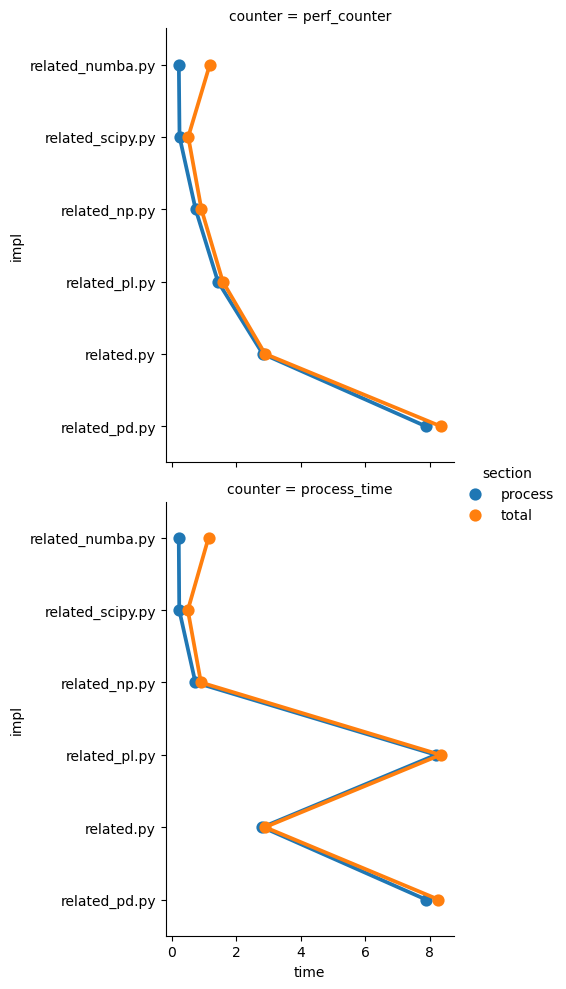

In [16]:
order = final_table.loc["perf_counter"].index
finals = times[["impl", "counter", "process", "total"]] \
    .groupby(["impl", "counter"]).last().reset_index() \
    .melt(id_vars=["impl", "counter"], var_name="section", value_name="time")
sns.catplot(finals, hue="section", y="impl", x="time",
            row="counter", kind="point",
            order=order)